In [90]:
import pandas as pd
import numpy as np
import pygeostat as gs
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

# example location

In [172]:
df = pd.DataFrame(
    {
        "id": [0, 1, 2, 3],
        "x": [0.5, -0.1, 1.1, 1.2],
        "y": [0, 0, 0, 0],
        "m": ["*", "o", "o", "o"],
        "s": [150, 15, 15, 15],
        "c": ["r", "k", "k", "k"]
    }
)

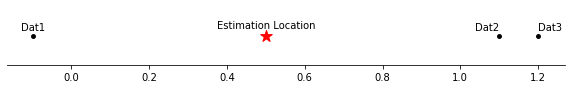

In [173]:
ax = None
for i, d in df.groupby("id"):
    s = d['m'].values[0]
    ax = d.plot(
        kind="scatter",
        x="x",
        y="y",
        c=d['c'].values[0],
        marker=d["m"].values[0],
        s=d["s"].values[0],
        figsize=(10, 10),
        ax=ax,
    )
    if s != "*":
        if i == 2:
            ha = "right"
        else: 
            ha = "left"
        ax.annotate(
            "Dat{}".format(d["id"].values[0]),
            (d["x"].values[0], d["y"].values[0]+ 0.001),
            xycoords="data",
            ha='center' if i not in (2, 3) else ha,
        )
    else: 
        ax.annotate(
            "Estimation Location",
            (d["x"].values[0], d["y"].values[0] + 0.001),
            xycoords="data",
            ha='center', 
            va='bottom'
        )
ax.set_ylim(-0.005, 0.005)
ax.set_aspect(15)
ax.set_ylabel("")
ax.set_xlabel("")
for d in ['left', 'right', 'top']:
    ax.spines[d].set_visible(False)
ax.yaxis.set_major_locator(plt.NullLocator())
gs.exportimg("example-screening.png")

In [174]:
class SphericalCovariance:
    def __init__(self, ne, r, sill=1.0):
        self.r = r
        self.ne = ne
        self.sill = sill

    def apply_diag(self, cov):
        if cov.ndim == 2 and cov.shape[0] == cov.shape[1]:
            cov[np.eye(cov.shape[0], dtype=bool)] = self.sill
        return cov

    def __call__(self, d):
        d = d / self.r
        cov = np.zeros_like(d)
        idxs = d < 1.0
        cov[idxs] = (self.sill - self.ne) * (1.0 - d[idxs] * (1.5 - 0.5 * d[idxs] ** 2))
        return self.apply_diag(cov)

In [175]:
cova = SphericalCovariance(0.001, 2.5)

In [176]:
xy = df[['x', 'y']].values

In [177]:
xy

array([[ 0.5,  0. ],
       [-0.1,  0. ],
       [ 1.1,  0. ],
       [ 1.2,  0. ]])

In [178]:
from scipy.spatial.distance import pdist, cdist, squareform

In [179]:
dists = squareform(pdist(xy))

In [180]:
dists

array([[0. , 0.6, 0.6, 0.7],
       [0.6, 0. , 1.2, 1.3],
       [0.6, 1.2, 0. , 0.1],
       [0.7, 1.3, 0.1, 0. ]])

In [181]:
covmat = cova(dists)

In [182]:
covmat

array([[1.        , 0.64626509, 0.64626509, 0.59038502],
       [0.64626509, 1.        , 0.3349607 , 0.2900137 ],
       [0.64626509, 0.3349607 , 1.        , 0.93909197],
       [0.59038502, 0.2900137 , 0.93909197, 1.        ]])

In [183]:
cov_df = pd.DataFrame(
    covmat,
    columns=["Estimation\nLocation", "Dat1", "Dat2", "Dat3"],
    index=["Estimation\nLocation", "Dat1", "Dat2", "Dat3"],
)

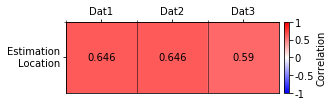

In [185]:
gs.corrmat(
    cov_df.loc[["Estimation\nLocation"], ["Dat1", "Dat2", "Dat3"]],
    figsize=(4, 4),
    cbar=True,
    cbar_label="Correlation",
)
gs.exportimg("corrmat-est-loc.png")

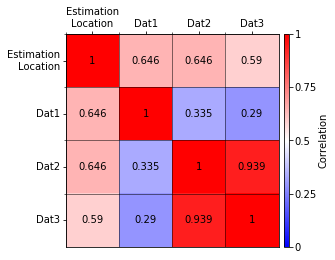

In [193]:
gs.corrmat(
    cov_df,
    vlim=(0, 1),
    figsize=(4, 4),
    cbar=True,
    cbar_label="Correlation",
)
gs.exportimg("corrmat-total.png")

In [188]:
weight_df = pd.DataFrame(
    np.atleast_2d(np.linalg.solve(covmat[1:, 1:], covmat[0, 1:])),
    columns=["Dat1", "Dat2", "Dat3"],
    index=["Estimation\nLocation"],
)

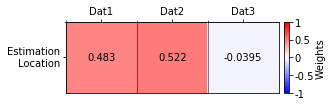

In [189]:
gs.corrmat(
    weight_df, figsize=(4, 4), cbar=True, cbar_label="Weights",
)
gs.exportimg("corrmat-weights.png")

In [190]:
ok_cmat = np.ones((4, 4))
ok_cmat[:3, :3] = covmat[1:, 1:]
ok_cmat[-1, -1] = 0
ok_rhs = np.ones(4)
ok_rhs[:3] = covmat[0, 1:]

In [191]:
weight_df = pd.DataFrame(
    np.atleast_2d(np.linalg.solve(ok_cmat, ok_rhs)[:3]),
    columns=["Dat1", "Dat2", "Dat3"],
    index=["Estimation\nLocation"],
)

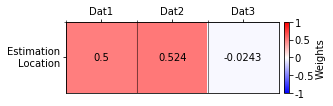

In [192]:
gs.corrmat(
    weight_df, figsize=(4, 4), cbar=True, cbar_label="Weights",
)
gs.exportimg("corrmat-ok-weights.png")